# **Pre-processing**

In [1]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load Fake.csv
fake = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "clmentbisaillon/fake-and-real-news-dataset",
    "Fake.csv"
)

# Load True.csv
true = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "clmentbisaillon/fake-and-real-news-dataset",
    "True.csv"
)

print("Fake news sample:")
print(fake.head())

print("\nTrue news sample:")
print(true.head())


/tmp/ipykernel_36/1226019658.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  fake = kagglehub.load_dataset(
/tmp/ipykernel_36/1226019658.py:12: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  true = kagglehub.load_dataset(


Fake news sample:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  

True news sample:
                                               title  \
0  As U.S. budget fight looms, Republicans flip

In [4]:
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [5]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


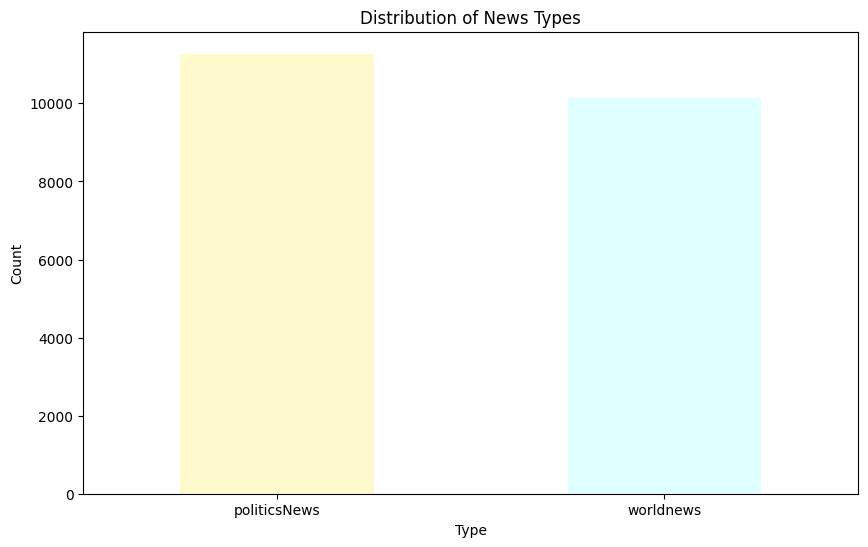

In [ ]:
import matplotlib.pyplot as plt


type_counts = true['subject'].value_counts()

plt.figure(figsize=(10,6))
type_counts.plot(kind='bar', color=[
#"#FFC1CC",  # Baby pink
"#FFFACD",  # (soft yellow)
"#E0FFFF",  # Light cyan
#"#D1C4E9",  # Lavender
#"#F8BBD0" ,   # Pink blush
#"#89CFF0"
])

plt.title("Distribution of News Types")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=0) 
plt.show()

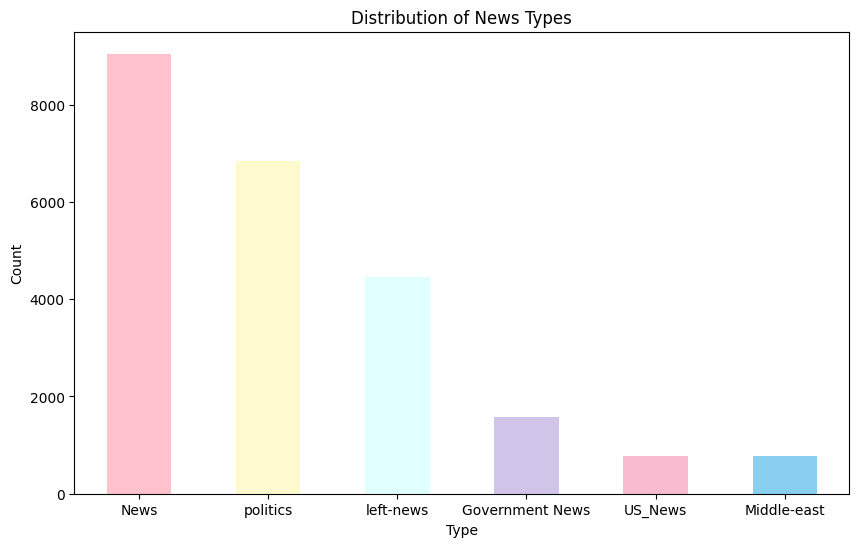

In [ ]:
import matplotlib.pyplot as plt


type_counts = fake['subject'].value_counts()

plt.figure(figsize=(10,6))
type_counts.plot(kind='bar', color=[
"#FFC1CC",  # Baby pink
"#FFFACD",  # (soft yellow)
"#E0FFFF",  # Light cyan
"#D1C4E9",  # Lavender
"#F8BBD0" ,   # Pink blush
"#89CFF0"
])

plt.title("Distribution of News Types")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=0) 
plt.show()


In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def clean(df):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

    for i in range(len(df)):
        sentence = df.loc[i , 'title_and_text']
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)

        sentence = word_tokenize(sentence)
        sentence = [word.lower() for word in sentence]
        sentence = [word for word in sentence if word not in stop_words]

        cleaned_tokens = []
        for token in sentence:
            token = re.sub(RE_TAGS, " ", token)
            token = re.sub(RE_ASCII, " ", token)
            token = re.sub(RE_SINGLECHAR, " ", token)
            token = re.sub(RE_WSPACE, " ", token)
            token = token.strip()
            if token:  # remove empty strings
                cleaned_tokens.append(token)

        #sentence = [lemmatizer.lemmatize(word) for word in cleaned_tokens]
        sentence = " ".join([lemmatizer.lemmatize(word) for word in cleaned_tokens])
        df.loc[i , 'title_and_text'] = sentence

    return df

In [5]:
fake['is_fake'] = 1
true['is_fake'] = 0

In [6]:
import pandas as pd

df = pd.concat([true, fake], ignore_index=True)
df.head()

,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [7]:
df['title_and_text'] = df['title'] + " " + df['text']

In [8]:
df = df.drop(columns = ['title' , 'text'])
df = df.drop(columns = ['subject' , 'date'])


In [9]:
df

,is_fake,title_and_text
0,0,"As U.S. budget fight looms, Republicans flip t..."
1,0,U.S. military to accept transgender recruits o...
2,0,Senior U.S. Republican senator: 'Let Mr. Muell...
3,0,FBI Russia probe helped by Australian diplomat...
4,0,Trump wants Postal Service to charge 'much mor...
...,...,...
44893,1,McPain: John McCain Furious That Iran Treated ...
44894,1,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
44895,1,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
44896,1,How to Blow $700 Million: Al Jazeera America F...


In [10]:
df  = clean(df)

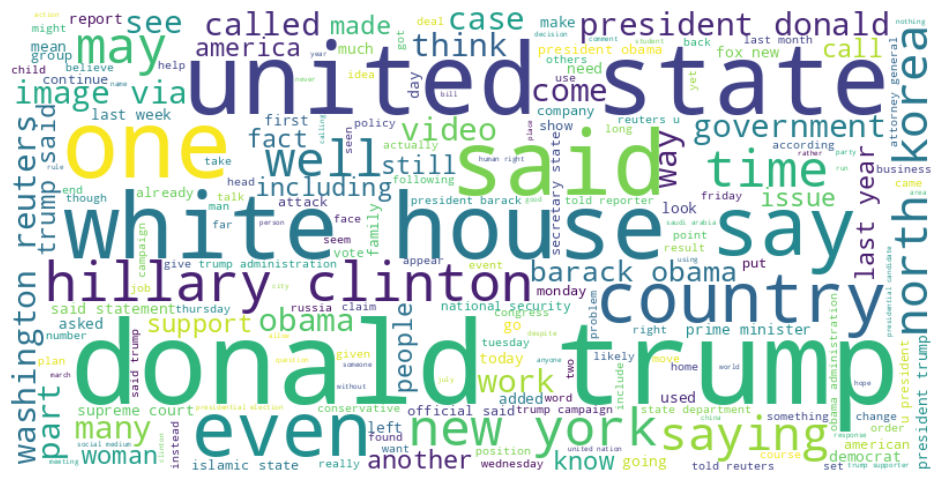

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_all = " ".join(df['title_and_text'])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_all)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


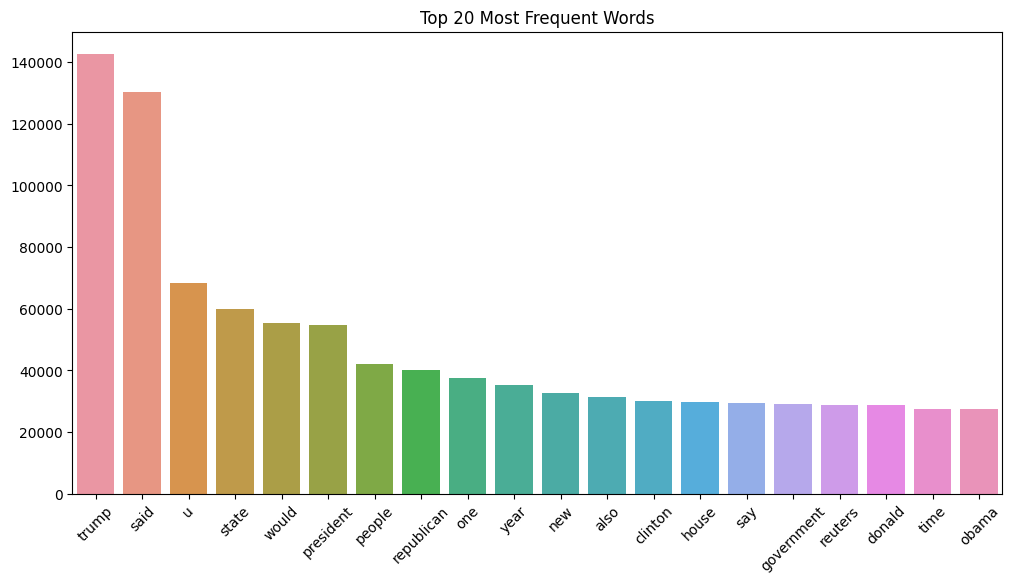

In [20]:
#frequency plot
from collections import Counter
import seaborn as sns

all_words = " ".join(df['title_and_text']).split()
word_counts = Counter(all_words)

common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.show()

# Word Representations

In [21]:
from gensim.models import Word2Vec
#we use the skip-gram word2vec
model_w2v = Word2Vec(df['title_and_text'], vector_size=100, window=5, sg=1)

In [22]:
def get_sentence_vector(sentence, model):
    words = [word for word in sentence if word in model.wv]
    if words:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

w2v_vectors = np.array([get_sentence_vector(sent, model_w2v) for sent in df['title_and_text']])
df["w2v_vector"] = list(w2v_vectors)

In [23]:
df.head()

,is_fake,title_and_text,w2v_vector
0,0,u budget fight loom republican flip fiscal scr...,"[0.076929495, 0.06263443, -0.093714066, 0.1975..."
1,0,u military accept transgender recruit monday p...,"[0.07767285, 0.06516019, -0.09783887, 0.196924..."
2,0,senior u republican senator let mr mueller job...,"[0.07948179, 0.06221854, -0.0975715, 0.1946347..."
3,0,fbi russia probe helped australian diplomat ti...,"[0.07730102, 0.061716624, -0.09581649, 0.19658..."
4,0,trump want postal service charge much amazon s...,"[0.07671918, 0.06460434, -0.0944633, 0.1998579..."


In [24]:
y = df['is_fake'].values
w2v_matrix = np.vstack(df['w2v_vector'].values)
X = np.hstack([w2v_matrix])

x_train_w2v, x_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X , y , test_size=0.2, random_state=42)

In [11]:
tfidf = TfidfVectorizer(
    max_features=5000,   
    ngram_range=(1,2),   
    stop_words='english'  
)
X_tfidf = tfidf.fit_transform(df['title_and_text'])
y = df['is_fake'].values

x_train_tf, x_test_tf , y_train_tf , y_test_tf = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

# **Classical Models -word2vec**

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   is_fake         44898 non-null  int64 
 1   title_and_text  44898 non-null  object
 2   w2v_vector      44898 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


# SVM

In [28]:
from sklearn.svm import SVC
classifier = SVC(probability=True, random_state=42)
classifier.fit(x_train_w2v , y_train_w2v)

SVC(probability=True, random_state=42)

In [29]:
y_pred = classifier.predict(x_test_w2v)

acc = accuracy_score(y_test_w2v, y_pred)
prec = precision_score(y_test_w2v, y_pred, average='weighted') 
rec = recall_score(y_test_w2v, y_pred, average='weighted')
f1 = f1_score(y_test_w2v, y_pred, average='weighted')

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

Accuracy: 0.756347438752784
Precision: 0.7562739091332865
Recall: 0.756347438752784
F1 Score: 0.7562505594882685


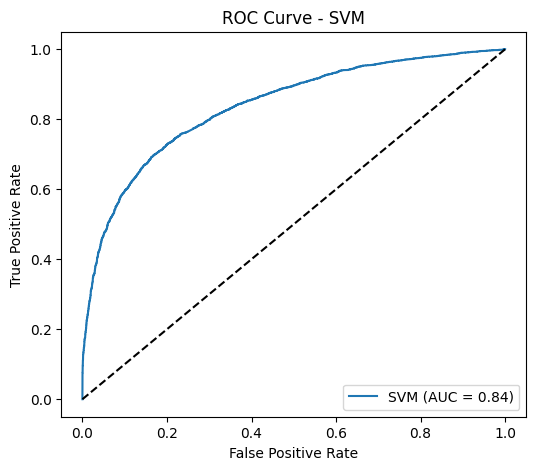

In [32]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

y_prob = classifier.predict_proba(x_test_w2v)[:,1]
y_pred = classifier.predict(x_test_w2v)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_w2v, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.show()

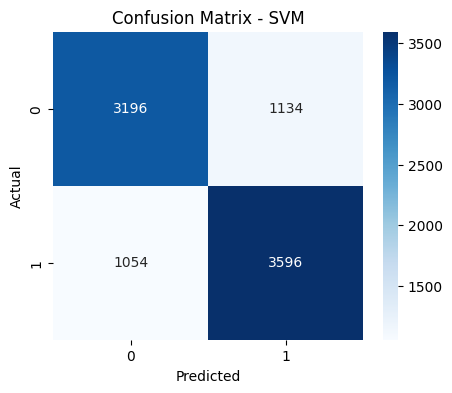

In [33]:
cm = confusion_matrix(y_test_w2v, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Logistic Regression

In [34]:
lr = LogisticRegression(penalty='l2', C=1.0)
lr.fit(x_train_w2v , y_train_w2v)

LogisticRegression()

In [35]:
y_pred = lr.predict(x_test_w2v)

acc = accuracy_score(y_test_w2v, y_pred)
prec = precision_score(y_test_w2v, y_pred, average='weighted') 
rec = recall_score(y_test_w2v, y_pred, average='weighted')
f1 = f1_score(y_test_w2v, y_pred, average='weighted')

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

Accuracy: 0.7262806236080178
Precision: 0.7343251818979943
Recall: 0.7262806236080178
F1 Score: 0.7223026619614397


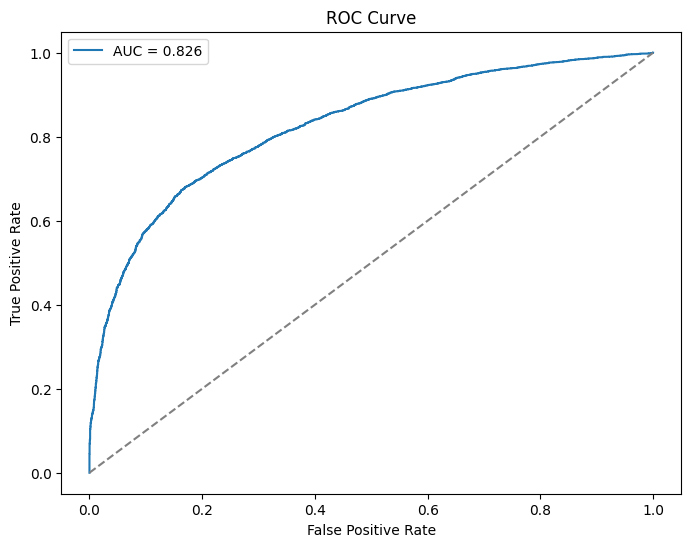

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_proba = lr.predict_proba(x_test_w2v)[:,1]  # probability for class 1
fpr, tpr, thresholds = roc_curve(y_test_w2v, y_proba)
auc = roc_auc_score(y_test_w2v, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


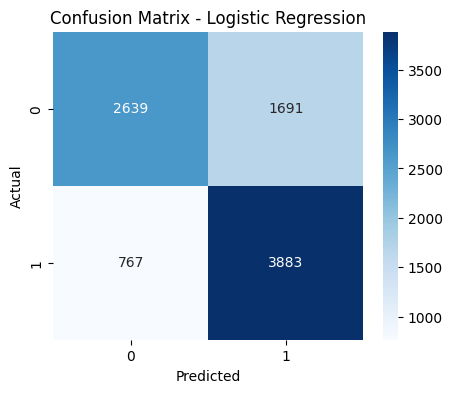

In [37]:
cm = confusion_matrix(y_test_w2v, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Naive Bayes

In [39]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train_w2v , y_train_w2v)

GaussianNB()

In [42]:
y_pred = nb.predict(x_test_w2v)

acc = accuracy_score(y_test_w2v, y_pred)
prec = precision_score(y_test_w2v, y_pred, average='weighted') 
rec = recall_score(y_test_w2v, y_pred, average='weighted')
f1 = f1_score(y_test_w2v, y_pred, average='weighted')

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

Accuracy: 0.7086859688195991
Precision: 0.7239498586702501
Recall: 0.7086859688195991
F1 Score: 0.7056859127404407


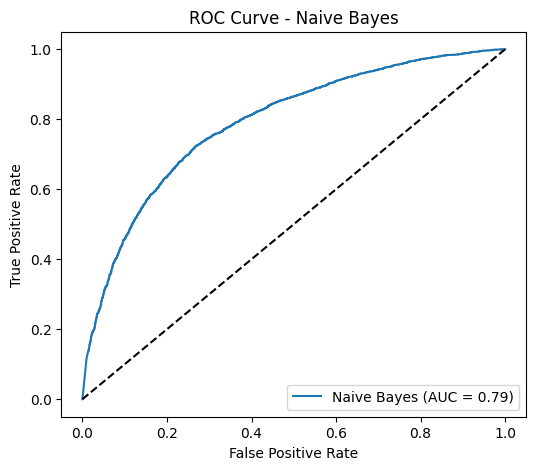

In [44]:
from sklearn.metrics import roc_curve, auc
y_prob = nb.predict_proba(x_test_w2v)[:,1]
y_pred = nb.predict(x_test_w2v)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_w2v, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Naive Bayes (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend(loc="lower right")
plt.show()


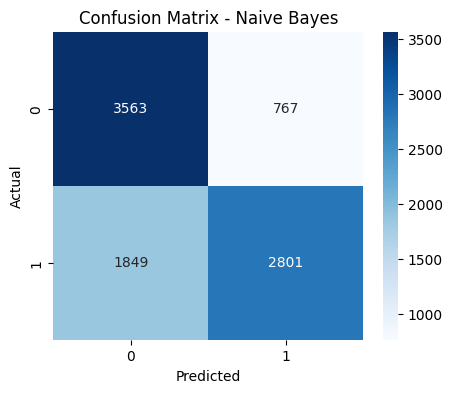

In [41]:
cm = confusion_matrix(y_test_w2v, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **Classical Models - TF-IDF**

# SVM

In [16]:
#from sklearn.svm import SVC
from cuml.svm import SVC #it had to be sped up as it was a bit slow on CPU
classifier = SVC(probability=True, random_state=42)
classifier.fit(x_train_tf , y_train_tf)

[2025-08-27 21:29:42.438] [CUML] [warning] Random state is currently ignored by probabilistic SVC


SVC()

In [17]:
y_pred = classifier.predict(x_test_tf)

acc = accuracy_score(y_test_tf, y_pred)
prec = precision_score(y_test_tf, y_pred, average='weighted') 
rec = recall_score(y_test_tf, y_pred, average='weighted')
f1 = f1_score(y_test_tf, y_pred, average='weighted')

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

Accuracy: 0.9944320712694877
Precision: 0.9944339966113478
Recall: 0.9944320712694877
F1 Score: 0.9944322438175732


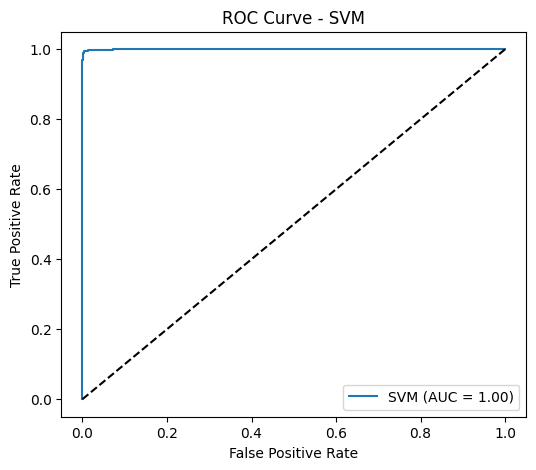

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

y_prob = classifier.predict_proba(x_test_tf)[:,1]
y_pred = classifier.predict(x_test_tf)

fpr, tpr, _ = roc_curve(y_test_tf, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))

plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.show()

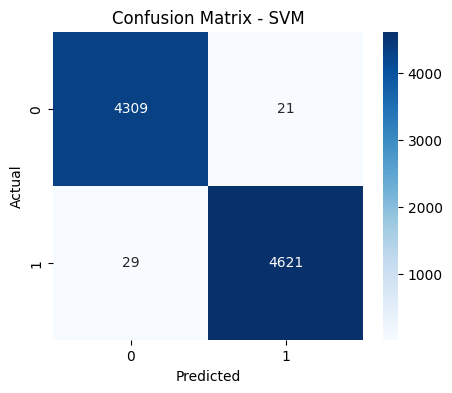

In [20]:
import seaborn as sns
cm = confusion_matrix(y_test_tf, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Logistic Regression

In [21]:
lr = LogisticRegression(penalty='l2', C=1.0)
lr.fit(x_train_tf , y_train_tf)

LogisticRegression()

In [22]:
y_pred = lr.predict(x_test_tf)

acc = accuracy_score(y_test_tf, y_pred)
prec = precision_score(y_test_tf, y_pred, average='weighted') 
rec = recall_score(y_test_tf, y_pred, average='weighted')
f1 = f1_score(y_test_tf, y_pred, average='weighted')

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

Accuracy: 0.9903118040089087
Precision: 0.9903241560556741
Recall: 0.9903118040089087
F1 Score: 0.9903125592097551


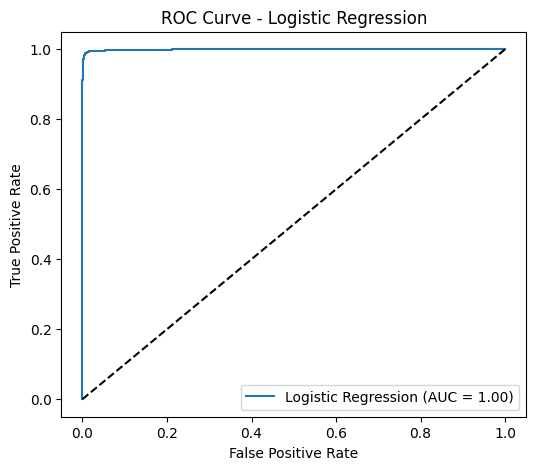

In [ ]:
from sklearn.metrics import roc_curve, auc
y_prob = lr.predict_proba(x_test_tf)[:,1]
y_pred = lr.predict(x_test_tf)

fpr, tpr, _ = roc_curve(y_test_tf, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()

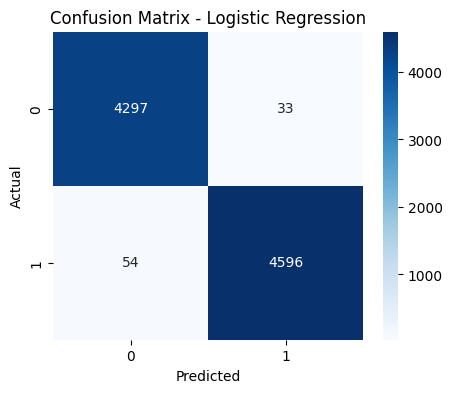

In [27]:
cm = confusion_matrix(y_test_tf, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Naive Bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(x_train_tf , y_train_tf)

MultinomialNB()

In [29]:
y_pred = nb.predict(x_test_tf)

acc = accuracy_score(y_test_tf, y_pred)
acc = accuracy_score(y_test_tf, y_pred)
prec = precision_score(y_test_tf, y_pred, average='weighted') 
rec = recall_score(y_test_tf, y_pred, average='weighted')
f1 = f1_score(y_test_tf, y_pred, average='weighted')

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

Accuracy: 0.9448775055679287
Precision: 0.9448802479064025
Recall: 0.9448775055679287
F1 Score: 0.9448785835001633


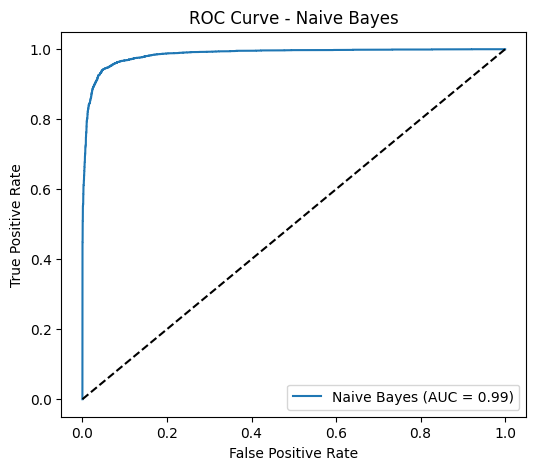

In [30]:
from sklearn.metrics import roc_curve, auc
y_prob = nb.predict_proba(x_test_tf)[:,1]
y_pred = nb.predict(x_test_tf)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_tf, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Naive Bayes (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend(loc="lower right")
plt.show()

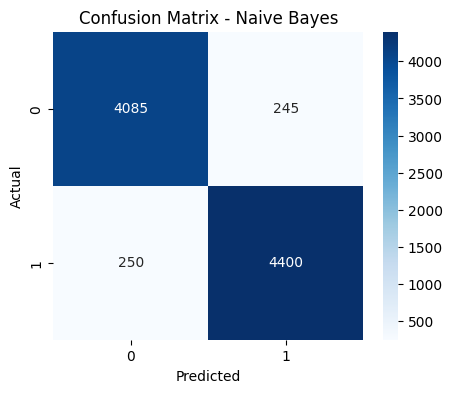

In [31]:
cm = confusion_matrix(y_test_tf, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()